In [1]:
pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.3/554.3 kB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=7c49544ee98bee59a33cfec0b9e802ccc760c7744fe1b68c5154162888a4aaa1
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=5a96f2dace2f9ab0687c947fb4d08b2b413f0ee72c8fe10b6ff1a0215afbdc3a
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built nvidia-ml-py3 configobj
Note: you may need to restart the kernel to use updated packages.


In [2]:
#running comet.ml
from comet_ml import Experiment

# connect
experiment = Experiment(
    api_key="ZlMjCC5LQUYW1u1nUBvLendvL",
    project_name="movie_recommendation_system",
    workspace="DataKing",
)
#experiment.set_name(name)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.com/dataking/movie-recommendation-system/183e8cbe896e47c0ba834fc680d8784f



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

COMET WARNING: Error exporting current conda environment
COMET WARNING: Unknown error exporting current conda environment


/kaggle/input/edsa-movie-recommendation-system/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-system/movies.csv
/kaggle/input/edsa-movie-recommendation-system/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-system/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-system/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-system/train.csv
/kaggle/input/edsa-movie-recommendation-system/test.csv
/kaggle/input/edsa-movie-recommendation-system/tags.csv
/kaggle/input/edsa-movie-recommendation-system/links.csv


In [4]:
g_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-system/genome_scores.csv')
g_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-system/genome_tags.csv')
imdb_data = pd.read_csv("/kaggle/input/edsa-movie-recommendation-system/imdb_data.csv")
links = pd.read_csv("/kaggle/input/edsa-movie-recommendation-system/links.csv")
movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-system/movies.csv')
train = pd.read_csv("/kaggle/input/edsa-movie-recommendation-system/train.csv")
test = pd.read_csv("/kaggle/input/edsa-movie-recommendation-system/train.csv")

# SELECTING MOVIES

When exploring videos in a video streaming site, or in a video shop, you will inevitably look for the following information as they will enable you find a movie that would likely interest you:
* Movie title
* Movie cast
* Director
* Genre
* Release year
* Reviews

Therefore, we will seek to determine if these factors in the next step, Exploratory Data Analysis, have an impact on the likelihood of a user to choose to watch a specific movie.

# EXPLORATORY DATA ANALYSIS

## EXPLORING THE DATA

In [5]:
g_scores.head(2)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375


In [6]:
g_tags.head(2)

,tagId,tag
0,1,007
1,2,007 (series)


In [7]:
imdb_data.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [8]:
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [9]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [10]:
train.head(2)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


To analyse the data efficiently, we will then need to merge the various dataframes into one dataframe. To do so, we will use the following keys:
* movieId
* userId
* imdbId
* tmdbId
* tagId

First, we will check whether the columns containing the keys have any null values:

In [11]:
g_scores.isna().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [12]:
g_tags.isna().sum()

tagId    0
tag      0
dtype: int64

In [13]:
imdb_data.isna().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [14]:
links.isna().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [15]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [16]:
train.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [17]:
test.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

From the above exercise, it was found that in all dataframes, the following columns (keys) do not have any null values: movieId, tagId, imdbId and userId. <br> The tmdbId column contains null values, and therefore the use of the links dataframe will be done with care.

Next, all relevant columns from the dataframes will be merged into the train dataframe.

In [18]:
# merging imdb_data dataframe into train dataframe and saving to another dataframe
# to add cast, director, runtime, budget and plot_keywords into the train dataframe
train_df = pd.merge(train, imdb_data, on='movieId')

In [19]:
train_df.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [20]:
# using merge function to add genre and title details to the train_df dataframe from the movies dataframe
train_df = pd.merge(train_df, movies, on = 'movieId')

In [21]:
train_df.head(2)

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller


From the train_df dataset, we can remove the timestamp and runtime columns:

In [22]:
#train_df.drop('timestamp','')

## RESEARCH QUESTIONS

* Q1: What are the number of users?
* Q2: What are the number of movies?
* Q3: What are the number of reviews given per user?
* Q4: What are the number of reviews per movie?
* Q5: What are the number of movies per rating level (0 to 5 at steps of 0.5)?
* Q6: Which movies were highly rated by most of the users?
* Q7: Are there outliers in users vs movies and ratings vs movies?


### Q1: What are the number of users?

In [23]:
# determining number of users by getting count of unique values
# in userId column of train dataframe
train['userId'].nunique()

162541

#### Observations:

* There are 162,541 unique reviewers of the movies

### Q2: What are the number of movies?

In [24]:
# determining number of movies by getting count of unique values
# in movieId column of train dataframe
train['movieId'].nunique()

48213

#### Observations

* There are 48,213 movies in the dataframe

### Q3: What are the Number of Reviews Given per User?

In [25]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [26]:
user_count = train.groupby(['userId']).count().reset_index()

In [27]:
user_count.head(3)

,userId,movieId,rating,timestamp
0,1,28,28,28
1,2,72,72,72
2,3,251,251,251


In [28]:
user_count['rating'].describe()

count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: rating, dtype: float64

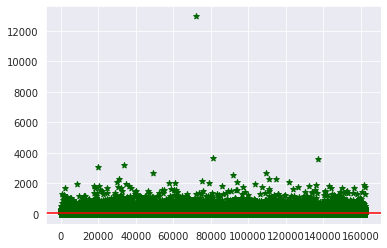

In [29]:
x = user_count['userId'].to_list()
y = user_count['movieId'].to_list()
mean = user_count['movieId'].mean()
fig = plt.figure()
ax = fig.add_subplot()
#ax.plot(x,mean, color = 'lightblue', linewidth = 3)
ax.scatter (x,y, color = 'darkgreen', marker = '*')
ax.axhline(mean, color = 'red')
#ax.set_xlim(1, 6.5)
plt.show()

#### Observations

It was observed that:
* There were users who rated only 1 movie, and one who rated 12,952 movies. The mean number of movies rated per user was 61

### Q4: What are the number of reviews per movie?

In [30]:
# using the movieId and rating columns in the train dataframe
# and grouping by movieId
movie_count = train.groupby(['movieId']).count().reset_index()
movie_count.head(3)

,movieId,userId,rating,timestamp
0,1,23062,23062,23062
1,2,9654,9654,9654
2,3,4727,4727,4727


In [31]:
movie_count['rating'].describe()

count    48213.000000
mean       207.413727
std       1092.768777
min          1.000000
25%          1.000000
50%          4.000000
75%         26.000000
max      32831.000000
Name: rating, dtype: float64

In [32]:
movie_count[movie_count['rating'] == 32831]

,movieId,userId,rating,timestamp
314,318,32831,32831,32831


In [33]:
movie_count[movie_count['rating'] <= 1].count()

movieId      12537
userId       12537
rating       12537
timestamp    12537
dtype: int64

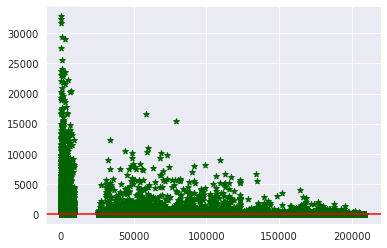

In [34]:
x = movie_count['movieId'].to_list()
y = movie_count['rating'].to_list()
mean = user_count['rating'].mean()
fig = plt.figure()
ax = fig.add_subplot()
#ax.plot(x,mean, color = 'lightblue', linewidth = 3)
ax.scatter (x,y, color = 'darkgreen', marker = '*')
ax.axhline(mean, color = 'red')
#ax.set_xlim(1, 6.5)
plt.show()

#### Observations

It was observed that:
* All the movies have ratings, as the minimum value of ratings in the movies_count dataframe is 1.
* 12,537 movies have number of ratings equal to one. This equates to 26% of the total number of movies present. This is a statistically significant number and can therefore have detrimental effects to the performance of the model
* The highest number of reviews for a movie is 32,831 reviews and is for movie with movieId 318.


### Q5: What are the number of movies per rating level (0 to 5 at steps of 0.5)?

In [35]:
ratings_count = train.groupby(['rating']).count().reset_index()
ratings_count.head(3)

,rating,userId,movieId,timestamp
0,0.5,157571,157571,157571
1,1.0,311213,311213,311213
2,1.5,159731,159731,159731


In [36]:
ratings_count.describe()

,rating,userId,movieId,timestamp
count,10.000000,1.000000e+01,1.000000e+01,1.000000e+01
mean,2.750000,1.000004e+06,1.000004e+06,1.000004e+06
std,1.513825,8.294318e+05,8.294318e+05,8.294318e+05
min,0.500000,1.575710e+05,1.575710e+05,1.575710e+05
25%,1.625000,3.598042e+05,3.598042e+05,3.598042e+05
50%,2.750000,7.686685e+05,7.686685e+05,7.686685e+05
75%,3.875000,1.401583e+06,1.401583e+06,1.401583e+06
max,5.000000,2.652977e+06,2.652977e+06,2.652977e+06


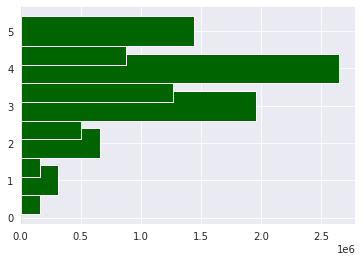

In [37]:
x = ratings_count['rating'].to_list()
y =ratings_count['movieId'].to_list()
mean = ratings_count['rating'].mean()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(x,mean, color = 'lightblue', linewidth = 3)
ax.barh (x,y, color = 'darkgreen')
ax.axvline(mean, color = 'red')
#ax.set_xlim(1, 6.5)
plt.show()

#### Observations

* A majority of the movies have ratings between 3 and 4, while the least being 0.5 to 2.5.
* the mean number of movies per rating is 1,000,004, where the minimum is 157,571 while the maximum is 2,652,977. 

### Q6: Which movies were highly rated by most of the users?

In [38]:
# Grouping by rating and then by the 


### Q7: Are there outliers in users vs movies and ratings vs movies?

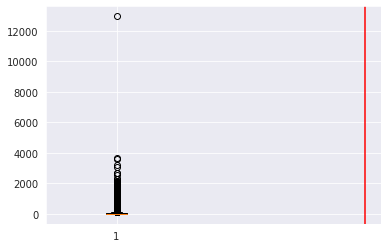

In [39]:
# users vs movies
# generating a candlestick

x = user_count['movieId'].to_list()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(x,mean, color = 'lightblue', linewidth = 3)
ax.boxplot (x)
ax.axvline(mean, color = 'red')
#ax.set_xlim(1, 6.5)
plt.show()


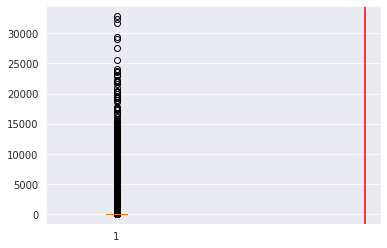

In [40]:
#ratings vs movies
#generating candle sticks

x = movie_count['rating'].to_list()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(x,mean, color = 'lightblue', linewidth = 3)
ax.boxplot (x)
ax.axvline(mean, color = 'red')
#ax.set_xlim(1, 6.5)
plt.show()

## ANTICIPATED CHALLENGES

The following are expected to influence the accuracy of the model:
* Presence of newly released movies whose level of confidence of ratings is not as high as for movies that have been released earlier.
* A new movie might not have enough ratings to match
* A new user had not watched enough movies to enable precise matching of the user with other users.